In [ ]:
# @title Imports

import dataclasses
import datetime
import functools
import math
import re
from typing import Optional

import cartopy.crs as ccrs
# from google.cloud import storage
# from graphcast import autoregressive
# from graphcast import casting
# from graphcast import checkpoint
# from graphcast import data_utils
# from graphcast import graphcast
# from graphcast import normalization
# from graphcast import rollout
# from graphcast import xarray_jax
# from graphcast import xarray_tree
from IPython.display import HTML
import ipywidgets as widgets
import haiku as hk
import jax
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import xarray


def parse_file_parts(file_name):
  return dict(part.split("-", 1) for part in file_name.split("_"))


# Loading forecasts from models

In [10]:
!pip install zarr xarray gcsfs


In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
import xarray as xr

graphcast_2020_prediction = xr.open_zarr('gs://weatherbench2/datasets/graphcast_hres_init/2020/date_range_2019-11-16_2021-02-01_12_hours-64x32_equiangular_conservative.zarr')

<ipython-input-2-7b5a497a71a5>:3: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  graphcast_2020_prediction = xr.open_zarr('gs://weatherbench2/datasets/graphcast_hres_init/2020/date_range_2019-11-16_2021-02-01_12_hours-64x32_equiangular_conservative.zarr')


## Graphcast Forecast

In [ ]:
graphcast_2020_prediction = xarray.open_zarr('gs://weatherbench2/datasets/graphcast_hres_init/2020/date_range_2019-11-16_2021-02-01_12_hours-64x32_equiangular_conservative.zarr')

In [ ]:
graphcast_2020_prediction

<xarray.Dataset> Size: 24GB
Dimensions:                   (time: 732, prediction_timedelta: 40,
                               longitude: 64, latitude: 32, level: 13)
Coordinates:
  * latitude                  (latitude) float64 256B -87.19 -81.56 ... 87.19
  * level                     (level) int32 52B 50 100 150 200 ... 850 925 1000
  * longitude                 (longitude) float64 512B 0.0 5.625 ... 348.8 354.4
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 320B 06:...
  * time                      (time) datetime64[ns] 6kB 2020-01-01 ... 2020-1...
Data variables: (12/14)
    10m_u_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 240MB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 240MB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, longitude, latitude) float32 240MB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, longitude, latitude) float32 240MB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, longitude, latitude) float32 3GB dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, longitude, latitude) float32 240MB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation_24hr  (time, prediction_timedelta, longitude, latitude) float32 240MB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, longitude, latitude) float32 240MB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 3GB dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 3GB dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    vertical_velocity         (time, prediction_timedelta, level, longitude, latitude) float32 3GB dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, longitude, latitude) float32 3GB dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>

In [ ]:
# @title Sliced Geopotential Z500 3-day forecast
#sliced_graphcast_predictions = graphcast_2020_prediction['geopotential'].sel(level=500,prediction_timedelta=np.timedelta64(72, 'h'), time = graphcast_2020_prediction.time.dt.hour == 0)
sliced_graphcast_predictions = graphcast_2020_prediction['geopotential'].sel(level=500,prediction_timedelta=np.timedelta64(72, 'h'))

In [ ]:
sliced_graphcast_predictions


<xarray.DataArray 'geopotential' (time: 732, longitude: 64, latitude: 32)> Size: 6MB
dask.array<getitem, shape=(732, 64, 32), dtype=float32, chunksize=(4, 64, 32), chunktype=numpy.ndarray>
Coordinates:
  * latitude              (latitude) float64 256B -87.19 -81.56 ... 81.56 87.19
    level                 int32 4B 500
  * longitude             (longitude) float64 512B 0.0 5.625 ... 348.8 354.4
    prediction_timedelta  timedelta64[ns] 8B 3 days
  * time                  (time) datetime64[ns] 6kB 2020-01-01 ... 2020-12-31...

In [ ]:
# @title  Save the sliced_graphcast_predictions

sliced_graphcast_predictions_file = "/content/GraphCast/forecasts/sliced_graphcast_predictions.nc"

sliced_graphcast_predictions.to_netcdf(sliced_graphcast_predictions_file)
print(f"sliced_graphcast_predictions saved to {sliced_graphcast_predictions_file}")

sliced_graphcast_predictions saved to /content/GraphCast/forecasts/sliced_graphcast_predictions.nc


## Pangu 2020 Forecasts

In [ ]:
pangu_2020_predictions  = xarray.open_zarr('gs://weatherbench2/datasets/pangu_hres_init/2020_0012_64x32_equiangular_conservative.zarr')

In [ ]:
pangu_2020_predictions

<xarray.Dataset> Size: 20GB
Dimensions:                  (time: 732, prediction_timedelta: 40,
                              longitude: 64, latitude: 32, level: 13)
Coordinates:
  * latitude                 (latitude) float64 256B -87.19 -81.56 ... 87.19
  * level                    (level) int64 104B 1000 925 850 700 ... 150 100 50
  * longitude                (longitude) float64 512B 0.0 5.625 ... 348.8 354.4
  * prediction_timedelta     (prediction_timedelta) timedelta64[ns] 320B 06:0...
  * time                     (time) datetime64[ns] 6kB 2020-01-01 ... 2020-12...
Data variables:
    10m_u_component_of_wind  (time, prediction_timedelta, longitude, latitude) float32 240MB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind  (time, prediction_timedelta, longitude, latitude) float32 240MB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed           (time, prediction_timedelta, longitude, latitude) float32 240MB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature           (time, prediction_timedelta, longitude, latitude) float32 240MB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential             (time, prediction_timedelta, level, longitude, latitude) float32 3GB dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure  (time, prediction_timedelta, longitude, latitude) float32 240MB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    specific_humidity        (time, prediction_timedelta, level, longitude, latitude) float32 3GB dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    temperature              (time, prediction_timedelta, level, longitude, latitude) float32 3GB dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    u_component_of_wind      (time, prediction_timedelta, level, longitude, latitude) float32 3GB dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind      (time, prediction_timedelta, level, longitude, latitude) float32 3GB dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    wind_speed               (time, prediction_timedelta, level, longitude, latitude) float32 3GB dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>

In [ ]:
# @title Sliced Geopotential Z500 3-day forecast
#sliced_pangu_predictions = pangu_2020_predictions['geopotential'].sel(level=500,prediction_timedelta=np.timedelta64(72, 'h'), time = pangu_2020_predictions.time.dt.hour == 0)
sliced_pangu_predictions = pangu_2020_predictions['geopotential'].sel(level=500,prediction_timedelta=np.timedelta64(72, 'h'))

In [ ]:
sliced_pangu_predictions

<xarray.DataArray 'geopotential' (time: 732, longitude: 64, latitude: 32)> Size: 6MB
dask.array<getitem, shape=(732, 64, 32), dtype=float32, chunksize=(4, 64, 32), chunktype=numpy.ndarray>
Coordinates:
  * latitude              (latitude) float64 256B -87.19 -81.56 ... 81.56 87.19
    level                 int64 8B 500
  * longitude             (longitude) float64 512B 0.0 5.625 ... 348.8 354.4
    prediction_timedelta  timedelta64[ns] 8B 3 days
  * time                  (time) datetime64[ns] 6kB 2020-01-01 ... 2020-12-31...

In [ ]:
# @title  Save the sliced_pangu_predictions

sliced_pangu_predictions_file = "/content/PanguWeather/forecasts/sliced_pangu_predictions.nc"

sliced_pangu_predictions.to_netcdf(sliced_pangu_predictions_file)
print(f"sliced_pangu_predictions saved to {sliced_pangu_predictions_file}")

sliced_pangu_predictions saved to /content/PanguWeather/forecasts/sliced_pangu_predictions.nc


## Fuxi Forecasts

In [ ]:
fuxi_2020_predictions = xarray.open_zarr('gs://weatherbench2/datasets/fuxi/2020-64x32_equiangular_conservative.zarr')

In [ ]:
fuxi_2020_predictions

<xarray.Dataset> Size: 6GB
Dimensions:                            (time: 702, prediction_timedelta: 60,
                                        longitude: 64, latitude: 32, level: 2)
Coordinates:
  * latitude                           (latitude) float64 256B -87.19 ... 87.19
  * level                              (level) int32 8B 500 850
  * longitude                          (longitude) float64 512B 0.0 ... 354.4
  * prediction_timedelta               (prediction_timedelta) timedelta64[ns] 480B ...
  * time                               (time) datetime64[ns] 6kB 2020-01-01 ....
Data variables:
    10m_u_component_of_wind            (time, prediction_timedelta, longitude, latitude) float32 345MB dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind            (time, prediction_timedelta, longitude, latitude) float32 345MB dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    10m_wind_speed                     (time, prediction_timedelta, longitude, latitude) float32 345MB dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    2m_temperature                     (time, prediction_timedelta, longitude, latitude) float32 345MB dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    geopotential                       (time, prediction_timedelta, level, longitude, latitude) float32 690MB dask.array<chunksize=(4, 60, 2, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure            (time, prediction_timedelta, longitude, latitude) float32 345MB dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    temperature                        (time, prediction_timedelta, level, longitude, latitude) float32 690MB dask.array<chunksize=(4, 60, 2, 64, 32), meta=np.ndarray>
    total_precipitation_24hr_from_6hr  (time, prediction_timedelta, longitude, latitude) float32 345MB dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    total_precipitation_6hr            (time, prediction_timedelta, longitude, latitude) float32 345MB dask.array<chunksize=(4, 60, 64, 32), meta=np.ndarray>
    u_component_of_wind                (time, prediction_timedelta, level, longitude, latitude) float32 690MB dask.array<chunksize=(4, 60, 2, 64, 32), meta=np.ndarray>
    v_component_of_wind                (time, prediction_timedelta, level, longitude, latitude) float32 690MB dask.array<chunksize=(4, 60, 2, 64, 32), meta=np.ndarray>
    wind_speed                         (time, prediction_timedelta, level, longitude, latitude) float32 690MB dask.array<chunksize=(4, 60, 2, 64, 32), meta=np.ndarray>

In [ ]:
# @title Sliced Geopotential Z500 3-day forecast
#sliced_fuxi_predictions = fuxi_2020_predictions['geopotential'].sel(level=500,prediction_timedelta=np.timedelta64(72, 'h'), time = fuxi_2020_predictions.time.dt.hour == 0)
sliced_fuxi_predictions = fuxi_2020_predictions['geopotential'].sel(level=500,prediction_timedelta=np.timedelta64(72, 'h'))

In [ ]:
sliced_fuxi_predictions

<xarray.DataArray 'geopotential' (time: 702, longitude: 64, latitude: 32)> Size: 6MB
dask.array<getitem, shape=(702, 64, 32), dtype=float32, chunksize=(4, 64, 32), chunktype=numpy.ndarray>
Coordinates:
  * latitude              (latitude) float64 256B -87.19 -81.56 ... 81.56 87.19
    level                 int32 4B 500
  * longitude             (longitude) float64 512B 0.0 5.625 ... 348.8 354.4
    prediction_timedelta  timedelta64[ns] 8B 3 days
  * time                  (time) datetime64[ns] 6kB 2020-01-01 ... 2020-12-16...

## NeuralGCM Deterministic Forecasts

In [ ]:
neuralgcm_2020_predictions = xarray.open_zarr('gs://weatherbench2/datasets/neuralgcm_deterministic/2020-64x32_equiangular_conservative.zarr')

In [ ]:
neuralgcm_2020_predictions

<xarray.Dataset> Size: 55GB
Dimensions:                              (time: 732, prediction_timedelta: 31,
                                          longitude: 64, latitude: 32, level: 37)
Coordinates:
  * latitude                             (latitude) float64 256B -87.19 ... 8...
  * level                                (level) int64 296B 1 2 3 ... 975 1000
  * longitude                            (longitude) float64 512B 0.0 ... 354.4
  * prediction_timedelta                 (prediction_timedelta) timedelta64[ns] 248B ...
  * time                                 (time) datetime64[ns] 6kB 2020-01-01...
Data variables:
    P_minus_E_cumulative                 (time, prediction_timedelta, longitude, latitude) float32 186MB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential                         (time, prediction_timedelta, level, longitude, latitude) float32 7GB dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    specific_cloud_ice_water_content     (time, prediction_timedelta, level, longitude, latitude) float32 7GB dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    specific_cloud_liquid_water_content  (time, prediction_timedelta, level, longitude, latitude) float32 7GB dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    specific_humidity                    (time, prediction_timedelta, level, longitude, latitude) float32 7GB dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    temperature                          (time, prediction_timedelta, level, longitude, latitude) float32 7GB dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    u_component_of_wind                  (time, prediction_timedelta, level, longitude, latitude) float32 7GB dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    v_component_of_wind                  (time, prediction_timedelta, level, longitude, latitude) float32 7GB dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
    wind_speed                           (time, prediction_timedelta, level, longitude, latitude) float32 7GB dask.array<chunksize=(4, 1, 37, 64, 32), meta=np.ndarray>
Attributes:
    experiment_id:  67001173
    worker_id:      1

In [ ]:
# @title Sliced Geopotential Z500 3-day forecast
#sliced_neuralgcm_predictions = neuralgcm_2020_predictions['geopotential'].sel(level=500,prediction_timedelta=np.timedelta64(72, 'h'), time = neuralgcm_2020_predictions.time.dt.hour == 0)
sliced_neuralgcm_predictions = neuralgcm_2020_predictions['geopotential'].sel(level=500,prediction_timedelta=np.timedelta64(72, 'h'))

In [ ]:
sliced_neuralgcm_predictions

<xarray.DataArray 'geopotential' (time: 732, longitude: 64, latitude: 32)> Size: 6MB
dask.array<getitem, shape=(732, 64, 32), dtype=float32, chunksize=(4, 64, 32), chunktype=numpy.ndarray>
Coordinates:
  * latitude              (latitude) float64 256B -87.19 -81.56 ... 81.56 87.19
    level                 int64 8B 500
  * longitude             (longitude) float64 512B 0.0 5.625 ... 348.8 354.4
    prediction_timedelta  timedelta64[ns] 8B 3 days
  * time                  (time) datetime64[ns] 6kB 2020-01-01 ... 2020-12-31...

In [ ]:
# @title  Save the sliced_neuralgcm_predictions

sliced_neuralgcm_predictions_file = "/content/NeuralGCM/forecasts/sliced_neuralgcm_predictions.nc"

sliced_neuralgcm_predictions.to_netcdf(sliced_neuralgcm_predictions_file)
print(f"sliced_neuralgcm_predictions saved to {sliced_neuralgcm_predictions_file}")

sliced_neuralgcm_predictions saved to /content/NeuralGCM/forecasts/sliced_neuralgcm_predictions.nc


## IFS

In [ ]:
ifs_forecasts = xarray.open_zarr('gs://weatherbench2/datasets/hres/2016-2022-0012-64x32_equiangular_conservative.zarr')

In [ ]:
ifs_forecasts

<xarray.Dataset> Size: 172GB
Dimensions:                   (time: 5114, prediction_timedelta: 41,
                               longitude: 64, latitude: 32, level: 13)
Coordinates:
  * latitude                  (latitude) float64 256B -87.19 -81.56 ... 87.19
  * level                     (level) int32 52B 50 100 150 200 ... 850 925 1000
  * longitude                 (longitude) float64 512B 0.0 5.625 ... 348.8 354.4
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 328B 00:...
  * time                      (time) datetime64[ns] 41kB 2016-01-01 ... 2022-...
Data variables: (12/16)
    10m_u_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, longitude, latitude) float32 22GB dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation_24hr  (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 22GB dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 22GB dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    vertical_velocity         (time, prediction_timedelta, level, longitude, latitude) float32 22GB dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, longitude, latitude) float32 22GB dask.array<chunksize=(4, 1, 13, 64, 32), meta=np.ndarray>

In [ ]:
# @title Sliced Geopotential Z500 3-day forecast
sliced_ifs_predictions = ifs_forecasts['geopotential'].sel(level=500,prediction_timedelta=np.timedelta64(72, 'h'), time =slice('2020-01-01T00:00:00.000000000','2020-12-31T12:00:00.000000000') )

In [ ]:
sliced_ifs_predictions

<xarray.DataArray 'geopotential' (time: 732, longitude: 64, latitude: 32)> Size: 6MB
dask.array<getitem, shape=(732, 64, 32), dtype=float32, chunksize=(4, 64, 32), chunktype=numpy.ndarray>
Coordinates:
  * latitude              (latitude) float64 256B -87.19 -81.56 ... 81.56 87.19
    level                 int32 4B 500
  * longitude             (longitude) float64 512B 0.0 5.625 ... 348.8 354.4
    prediction_timedelta  timedelta64[ns] 8B 3 days
  * time                  (time) datetime64[ns] 6kB 2020-01-01 ... 2020-12-31...
Attributes:
    long_name:      Geopotential
    short_name:     z
    standard_name:  geopotential
    units:          m**2 s**-2

In [ ]:
# @title  Save the sliced_IFS_predictions

sliced_ifs_predictions_file = "/content/IFS/forecasts/sliced_ifs_predictions.nc"

sliced_ifs_predictions.to_netcdf(sliced_ifs_predictions_file)
print(f"sliced_ifs_predictions saved to {sliced_ifs_predictions_file}")

sliced_ifs_predictions saved to /content/IFS/forecasts/sliced_ifs_predictions.nc


## IFS ENS Mean

In [ ]:
ifsEns_mean_forecasts = xarray.open_zarr('gs://weatherbench2/datasets/ifs_ens/2018-2022-64x32_equiangular_conservative_mean.zarr')

In [ ]:
ifsEns_mean_forecasts

<xarray.Dataset> Size: 53GB
Dimensions:                   (time: 3652, prediction_timedelta: 61,
                               longitude: 64, latitude: 32, level: 3)
Coordinates:
  * latitude                  (latitude) float64 256B -87.19 -81.56 ... 87.19
  * level                     (level) int32 12B 500 700 850
  * longitude                 (longitude) float64 512B 0.0 5.625 ... 348.8 354.4
  * prediction_timedelta      (prediction_timedelta) timedelta64[ns] 488B 00:...
  * time                      (time) datetime64[ns] 29kB 2018-01-01 ... 2022-...
Data variables: (12/15)
    10m_u_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind   (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    10m_wind_speed            (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    2m_temperature            (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    geopotential              (time, prediction_timedelta, level, longitude, latitude) float32 5GB dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    mean_sea_level_pressure   (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    ...                        ...
    total_precipitation       (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_24hr  (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    total_precipitation_6hr   (time, prediction_timedelta, longitude, latitude) float32 2GB dask.array<chunksize=(4, 1, 64, 32), meta=np.ndarray>
    u_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 5GB dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    v_component_of_wind       (time, prediction_timedelta, level, longitude, latitude) float32 5GB dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>
    wind_speed                (time, prediction_timedelta, level, longitude, latitude) float32 5GB dask.array<chunksize=(4, 1, 3, 64, 32), meta=np.ndarray>

In [ ]:
# @title Sliced Geopotential Z500 3-day forecast
sliced_ifsEns_mean_forecasts = ifsEns_mean_forecasts['geopotential'].sel(level=500,prediction_timedelta=np.timedelta64(72, 'h'), time =slice('2020-01-01T00:00:00.000000000','2020-12-31T12:00:00.000000000') )

In [ ]:
sliced_ifsEns_mean_forecasts

<xarray.DataArray 'geopotential' (time: 732, longitude: 64, latitude: 32)> Size: 6MB
dask.array<getitem, shape=(732, 64, 32), dtype=float32, chunksize=(4, 64, 32), chunktype=numpy.ndarray>
Coordinates:
  * latitude              (latitude) float64 256B -87.19 -81.56 ... 81.56 87.19
    level                 int32 4B 500
  * longitude             (longitude) float64 512B 0.0 5.625 ... 348.8 354.4
    prediction_timedelta  timedelta64[ns] 8B 3 days
  * time                  (time) datetime64[ns] 6kB 2020-01-01 ... 2020-12-31...
Attributes:
    long_name:      Geopotential
    short_name:     z
    standard_name:  geopotential
    units:          m**2 s**-2

In [ ]:
# @title  Save the sliced_ifs_mean_forecasts

sliced_ifsEns_mean_forecasts_file = "/content/IFSENSMean/forecasts/sliced_ifsEns_mean_forecasts.nc"

sliced_ifsEns_mean_forecasts.to_netcdf(sliced_ifsEns_mean_forecasts_file)
print(f"sliced_ifs_mean_forecasts saved to {sliced_ifsEns_mean_forecasts_file}")

sliced_ifs_mean_forecasts saved to /content/IFSENSMean/forecasts/sliced_ifsEns_mean_forecasts.nc


## ERA5 Ground truth Data

In [ ]:
era5_ground_truth = xarray.open_zarr('gs://weatherbench2/datasets/era5/1959-2023_01_10-6h-64x32_equiangular_conservative.zarr')

In [ ]:
era5_ground_truth

<xarray.Dataset> Size: 175GB
Dimensions:                                           (time: 93544,
                                                       longitude: 64,
                                                       latitude: 32, level: 13)
Coordinates:
  * latitude                                          (latitude) float64 256B ...
  * level                                             (level) int64 104B 50 ....
  * longitude                                         (longitude) float64 512B ...
  * time                                              (time) datetime64[ns] 748kB ...
Data variables: (12/62)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 766MB dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind                           (time, longitude, latitude) float32 766MB dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    10m_wind_speed                                    (time, longitude, latitude) float32 766MB dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    2m_dewpoint_temperature                           (time, longitude, latitude) float32 766MB dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    2m_temperature                                    (time, longitude, latitude) float32 766MB dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    above_ground                                      (time, level, longitude, latitude) float32 10GB dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    ...                                                ...
    volumetric_soil_water_layer_1                     (time, longitude, latitude) float32 766MB dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    volumetric_soil_water_layer_2                     (time, longitude, latitude) float32 766MB dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    volumetric_soil_water_layer_3                     (time, longitude, latitude) float32 766MB dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    volumetric_soil_water_layer_4                     (time, longitude, latitude) float32 766MB dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    vorticity                                         (time, level, longitude, latitude) float32 10GB dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    wind_speed                                        (time, level, longitude, latitude) float32 10GB dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>

In [ ]:
# @title Sliced Geopotential Z500 Ground truth
sliced_era5_ground_truth = era5_ground_truth['geopotential'].sel(
    level=500,
    time = era5_ground_truth.time[
        (era5_ground_truth.time >=np.datetime64('2020-01-01T00:00:00.000000000')) &
        (era5_ground_truth.time <=np.datetime64('2020-12-31T12:00:00.000000000')) &
        (era5_ground_truth.time.dt.hour.isin([0, 12]))
    ]
)

In [ ]:
sliced_era5_ground_truth

<xarray.DataArray 'geopotential' (time: 732, longitude: 64, latitude: 32)> Size: 6MB
dask.array<getitem, shape=(732, 64, 32), dtype=float32, chunksize=(99, 64, 32), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 256B -87.19 -81.56 -75.94 ... 81.56 87.19
    level      int64 8B 500
  * longitude  (longitude) float64 512B 0.0 5.625 11.25 ... 343.1 348.8 354.4
  * time       (time) datetime64[ns] 6kB 2020-01-01 ... 2020-12-31T12:00:00
Attributes:
    long_name:      Geopotential
    short_name:     z
    standard_name:  geopotential
    units:          m**2 s**-2

In [ ]:
# @title  Save the sliced_era5_ground_truth

sliced_era5_ground_truth_file = "/content/ERA5/groundtruth/sliced_era5_ground_truth.nc"

sliced_era5_ground_truth.to_netcdf(sliced_era5_ground_truth_file)
print(f"sliced_era5_ground_truth saved to {sliced_era5_ground_truth_file}")

sliced_era5_ground_truth saved to /content/ERA5/groundtruth/sliced_era5_ground_truth.nc


In [ ]:
# @title  Load saved forecasts (GraphCast, PanguWeather, NeuralGCM)

# GraphCast
sliced_graphcast_predictions_file = "/content/GraphCast/forecasts/sliced_graphcast_predictions.nc"
sliced_graphcast_predictions = xarray.open_dataset(sliced_graphcast_predictions_file)
print(f"sliced_graphcast_predictions loaded from {sliced_graphcast_predictions_file}")

# PanguWeather
sliced_pangu_predictions_file = "/content/PanguWeather/forecasts/sliced_pangu_predictions.nc"
sliced_pangu_predictions = xarray.open_dataset(sliced_pangu_predictions_file)
print(f"sliced_pangu_predictions loaded from {sliced_pangu_predictions_file}")

# NeuralGCM
sliced_neuralgcm_predictions_file = "/content/NeuralGCM/forecasts/sliced_neuralgcm_predictions.nc"
sliced_neuralgcm_predictions = xarray.open_dataset(sliced_neuralgcm_predictions_file)
print(f"sliced_neuralgcm_predictions loaded from {sliced_neuralgcm_predictions_file}")

sliced_graphcast_predictions loaded from /content/GraphCast/forecasts/sliced_graphcast_predictions.nc
sliced_pangu_predictions loaded from /content/PanguWeather/forecasts/sliced_pangu_predictions.nc
sliced_neuralgcm_predictions loaded from /content/NeuralGCM/forecasts/sliced_neuralgcm_predictions.nc


In [ ]:
# @title Check dataset dimensions
print(sliced_graphcast_predictions.dims)
print(sliced_pangu_predictions.dims)
print(sliced_neuralgcm_predictions.dims)


FrozenMappingWarningOnValuesAccess({'latitude': 32, 'longitude': 64, 'time': 732})
FrozenMappingWarningOnValuesAccess({'latitude': 32, 'longitude': 64, 'time': 732})
FrozenMappingWarningOnValuesAccess({'latitude': 32, 'longitude': 64, 'time': 732})


In [ ]:
# @title Rename Geopotential to distiguished models

#GraphCast
sliced_graphcast_predictions =sliced_graphcast_predictions.rename({'geopotential': "graphcast_pred"})
#PanguWeather
sliced_pangu_predictions =sliced_pangu_predictions.rename({'geopotential': "pangu_pred"})
#NeuralGCM
sliced_neuralgcm_predictions =sliced_neuralgcm_predictions.rename({'geopotential': "neuralgcm_pred"})


In [ ]:
print(sliced_graphcast_predictions)
print(sliced_pangu_predictions)
print(sliced_neuralgcm_predictions)

<xarray.Dataset> Size: 6MB
Dimensions:               (latitude: 32, longitude: 64, time: 732)
Coordinates:
  * latitude              (latitude) float64 256B -87.19 -81.56 ... 81.56 87.19
    level                 int32 4B ...
  * longitude             (longitude) float64 512B 0.0 5.625 ... 348.8 354.4
    prediction_timedelta  timedelta64[ns] 8B ...
  * time                  (time) datetime64[ns] 6kB 2020-01-01 ... 2020-12-31...
Data variables:
    graphcast_pred        (time, longitude, latitude) float32 6MB ...
<xarray.Dataset> Size: 6MB
Dimensions:               (latitude: 32, longitude: 64, time: 732)
Coordinates:
  * latitude              (latitude) float64 256B -87.19 -81.56 ... 81.56 87.19
    level                 int64 8B ...
  * longitude             (longitude) float64 512B 0.0 5.625 ... 348.8 354.4
    prediction_timedelta  timedelta64[ns] 8B ...
  * time                  (time) datetime64[ns] 6kB 2020-01-01 ... 2020-12-31...
Data variables:
    pangu_pred            (time,

In [ ]:
# @title Merge all Model predictions into one dataset
merged_predictions = xarray.merge([
    sliced_graphcast_predictions,
    sliced_pangu_predictions,
    sliced_neuralgcm_predictions
])
merged_predictions

<xarray.Dataset> Size: 18MB
Dimensions:               (latitude: 32, longitude: 64, time: 732)
Coordinates:
  * latitude              (latitude) float64 256B -87.19 -81.56 ... 81.56 87.19
    level                 int64 8B 500
  * longitude             (longitude) float64 512B 0.0 5.625 ... 348.8 354.4
    prediction_timedelta  timedelta64[ns] 8B 3 days
  * time                  (time) datetime64[ns] 6kB 2020-01-01 ... 2020-12-31...
Data variables:
    graphcast_pred        (time, longitude, latitude) float32 6MB ...
    pangu_pred            (time, longitude, latitude) float32 6MB ...
    neuralgcm_pred        (time, longitude, latitude) float32 6MB ...

In [ ]:
# @title Load and Merge ERA5 Ground Truth

# Load
sliced_era5_ground_truth_file = "/content/ERA5/groundtruth/sliced_era5_ground_truth.nc"
sliced_era5_ground_truth=xarray.open_dataset(sliced_era5_ground_truth_file)
print(f"sliced_era5_ground_truth loaded from {sliced_era5_ground_truth_file}\n")

# rename geopotential variable to era5 for clarity
sliced_era5_ground_truth = sliced_era5_ground_truth.rename({"geopotential":"era5_ground_truth"})
print(sliced_era5_ground_truth)

# merge ground truth with predictions
final_dataset = xarray.merge([merged_predictions,  sliced_era5_ground_truth])
print(final_dataset)

sliced_era5_ground_truth loaded from /content/ERA5/groundtruth/sliced_era5_ground_truth.nc

<xarray.Dataset> Size: 6MB
Dimensions:            (latitude: 32, longitude: 64, time: 732)
Coordinates:
  * latitude           (latitude) float64 256B -87.19 -81.56 ... 81.56 87.19
    level              int64 8B ...
  * longitude          (longitude) float64 512B 0.0 5.625 11.25 ... 348.8 354.4
  * time               (time) datetime64[ns] 6kB 2020-01-01 ... 2020-12-31T12...
Data variables:
    era5_ground_truth  (time, longitude, latitude) float32 6MB ...
<xarray.Dataset> Size: 24MB
Dimensions:               (latitude: 32, longitude: 64, time: 732)
Coordinates:
  * latitude              (latitude) float64 256B -87.19 -81.56 ... 81.56 87.19
    level                 int64 8B 500
  * longitude             (longitude) float64 512B 0.0 5.625 ... 348.8 354.4
    prediction_timedelta  timedelta64[ns] 8B 3 days
  * time                  (time) datetime64[ns] 6kB 2020-01-01 ... 2020-12-31...
Data varia

In [ ]:
final_dataset.dims

FrozenMappingWarningOnValuesAccess({'latitude': 32, 'longitude': 64, 'time': 732})

In [ ]:
df = final_dataset.stack().to_dataframe().reset_index()
df

,latitude,longitude,time,level,prediction_timedelta,graphcast_pred,pangu_pred,neuralgcm_pred,era5_ground_truth
0,-87.1875,0.000,2020-01-01 00:00:00,500,3 days,49969.980469,49928.015625,50061.421875,49846.941406
1,-87.1875,0.000,2020-01-01 12:00:00,500,3 days,50021.562500,49925.054688,50081.550781,49735.156250
2,-87.1875,0.000,2020-01-02 00:00:00,500,3 days,49888.203125,49812.093750,49980.234375,49807.484375
3,-87.1875,0.000,2020-01-02 12:00:00,500,3 days,49763.714844,49607.906250,49767.320312,49791.328125
4,-87.1875,0.000,2020-01-03 00:00:00,500,3 days,49927.558594,49726.312500,49899.242188,49885.296875
...,...,...,...,...,...,...,...,...,...
1499131,87.1875,354.375,2020-12-29 12:00:00,500,3 days,51104.945312,50822.031250,51062.234375,51045.476562
1499132,87.1875,354.375,2020-12-30 00:00:00,500,3 days,50479.910156,50673.753906,50443.011719,51353.539062
1499133,87.1875,354.375,2020-12-30 12:00:00,500,3 days,50633.886719,50590.609375,50523.417969,51772.277344
1499134,87.1875,354.375,2020-12-31 00:00:00,500,3 days,50799.078125,50937.414062,50634.812500,52045.835938


In [ ]:
df.head()

,latitude,longitude,time,level,prediction_timedelta,graphcast_pred,pangu_pred,neuralgcm_pred,era5_ground_truth
0,-87.1875,0.0,2020-01-01 00:00:00,500,3 days,49969.980469,49928.015625,50061.421875,49846.941406
1,-87.1875,0.0,2020-01-01 12:00:00,500,3 days,50021.562500,49925.054688,50081.550781,49735.156250
2,-87.1875,0.0,2020-01-02 00:00:00,500,3 days,49888.203125,49812.093750,49980.234375,49807.484375
3,-87.1875,0.0,2020-01-02 12:00:00,500,3 days,49763.714844,49607.906250,49767.320312,49791.328125
4,-87.1875,0.0,2020-01-03 00:00:00,500,3 days,49927.558594,49726.312500,49899.242188,49885.296875


In [ ]:
# @title select features and targets
x= df[["graphcast_pred","pangu_pred","neuralgcm_pred"]]
y=df["era5_ground_truth"]

In [ ]:
x

,graphcast_pred,pangu_pred,neuralgcm_pred
0,49969.980469,49928.015625,50061.421875
1,50021.562500,49925.054688,50081.550781
2,49888.203125,49812.093750,49980.234375
3,49763.714844,49607.906250,49767.320312
4,49927.558594,49726.312500,49899.242188
...,...,...,...
1499131,51104.945312,50822.031250,51062.234375
1499132,50479.910156,50673.753906,50443.011719
1499133,50633.886719,50590.609375,50523.417969
1499134,50799.078125,50937.414062,50634.812500


In [ ]:
y

,era5_ground_truth
0,49846.941406
1,49735.156250
2,49807.484375
3,49791.328125
4,49885.296875
...,...
1499131,51045.476562
1499132,51353.539062
1499133,51772.277344
1499134,52045.835938


In [ ]:
# @title Train Random Forest Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

#split data into train and test
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state=42)

In [ ]:
# train the random forest regressor
from joblib import Parallel, delayed
import time

rf = RandomForestRegressor(n_estimators=10, random_state=42, verbose=1, warm_start=True, n_jobs=-1)

start_time = time.time()
rf.fit(x_train,y_train)
end_time = time.time()

print(f"Training completed in {end_time - start_time:.2f} seconds")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Training completed in 17.97 seconds


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.9s finished


In [ ]:
#evaluate model
score =rf.score(x_test, y_test)
print(f"Random Forest R^2 Score: {score:.4f}")

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


Random Forest R^2 Score: 0.8979


[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.4s remaining:    1.5s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.4s finished


In [ ]:
rf = RandomForestRegressor(n_estimators=10, random_state=42, verbose=1, warm_start=True, n_jobs=-1)

In [ ]:
from sklearn.metrics import r2_score
train_scores = []
num_trees = []

for i in range(10, 101, 10):  # Increase trees in batches of 10
    rf.n_estimators = i
    num_trees.append(i)

    start_time = time.time()
    rf.fit(x_train, y_train) # Continue training
    end_time = time.time()
    print(f"Training completed in {end_time - start_time:.2f} seconds")

    y_pred = rf.predict(x_test)
    score = r2_score(y_test, y_pred)
    train_scores.append(score)

    print(f"Trained {i} trees - R² Score: {score:.4f}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


Training completed in 18.28 seconds


[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.4s remaining:    1.5s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Trained 10 trees - R² Score: 0.8979


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   19.4s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Training completed in 19.39 seconds


[Parallel(n_jobs=16)]: Done  10 out of  20 | elapsed:    0.5s remaining:    0.5s
[Parallel(n_jobs=16)]: Done  20 out of  20 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Trained 20 trees - R² Score: 0.9020


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Training completed in 18.66 seconds


[Parallel(n_jobs=16)]: Done  30 out of  30 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Trained 30 trees - R² Score: 0.9035


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Training completed in 17.68 seconds


[Parallel(n_jobs=16)]: Done  40 out of  40 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Trained 40 trees - R² Score: 0.9042


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Training completed in 18.64 seconds


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    1.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Trained 50 trees - R² Score: 0.9046


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   18.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Training completed in 18.84 seconds


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done  60 out of  60 | elapsed:    1.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Trained 60 trees - R² Score: 0.9049


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Training completed in 17.82 seconds


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done  70 out of  70 | elapsed:    2.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Trained 70 trees - R² Score: 0.9051


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.8s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Training completed in 17.86 seconds


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done  80 out of  80 | elapsed:    2.3s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Trained 80 trees - R² Score: 0.9052


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Training completed in 17.68 seconds


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.9s
[Parallel(n_jobs=16)]: Done  90 out of  90 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


Trained 90 trees - R² Score: 0.9053


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.7s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.


Training completed in 17.73 seconds


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.9s


Trained 100 trees - R² Score: 0.9054


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    3.1s finished


In [ ]:
# @title Save the trained model
import joblib

joblib.dump(rf, "random_forest_model.pkl")

print("Model saved as random_forest_model.pkl")


Model saved as random_forest_model.pkl


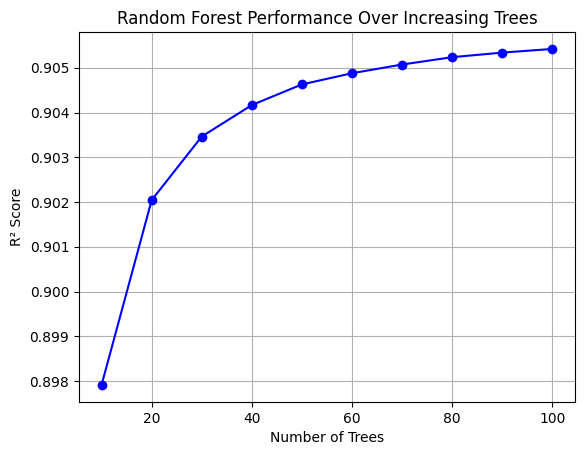

In [ ]:
import matplotlib.pyplot as plt

plt.plot(num_trees, train_scores, marker='o', linestyle='-', color='b')
plt.xlabel("Number of Trees")
plt.ylabel("R² Score")
plt.title("Random Forest Performance Over Increasing Trees")
plt.grid(True)
plt.savefig('Random_forest_r2_performance.pdf', dpi=300, bbox_inches="tight")
plt.show()
